In [73]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

In [74]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','NO2','NOX','O3','PM2_5'])
one_feature.head(5)

,Start,PM10
0,2015-01-01 00:00:00,28.4
1,2015-01-01 01:00:00,8.5
2,2015-01-01 02:00:00,8.7
3,2015-01-01 03:00:00,10.5
4,2015-01-01 04:00:00,12.1


# 1) Pre-processing

#### Creating Test and train datasets

In [75]:
train=one_feature[(one_feature['Start']<= "2018-12-31 23:00:00")]
test=one_feature[(one_feature['Start'] >= "2019-01-01 00:00:00")]

#### Visualization

,index,Start,PM10
0,0,2015-01-01 00:00:00,28.4
1,1,2015-01-01 01:00:00,8.5
2,2,2015-01-01 02:00:00,8.7
3,3,2015-01-01 03:00:00,10.5
4,4,2015-01-01 04:00:00,12.1
...,...,...,...
35059,35059,2018-12-31 19:00:00,4.8
35060,35060,2018-12-31 20:00:00,7.8
35061,35061,2018-12-31 21:00:00,7.4
35062,35062,2018-12-31 22:00:00,6.7


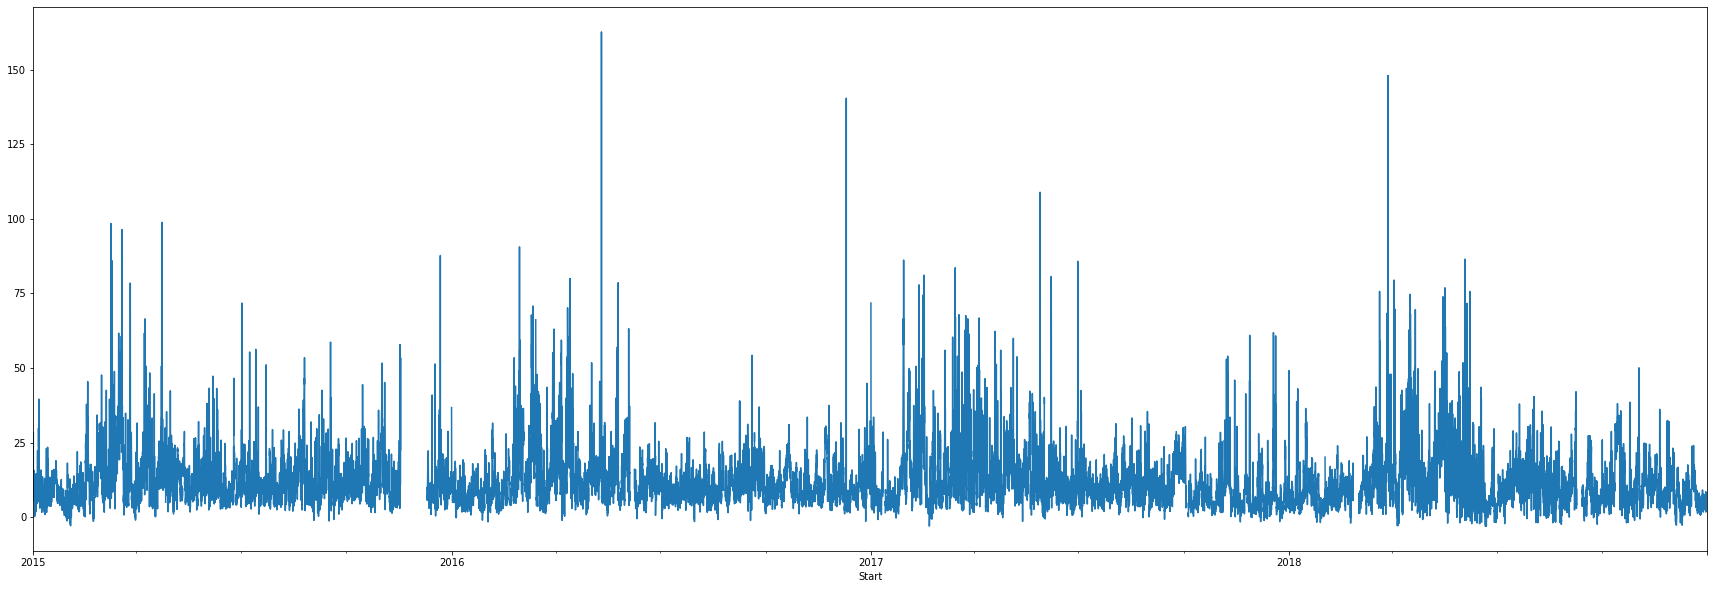

In [76]:
train.set_index('Start')['PM10'].plot(figsize = (30,10))
train.reset_index()
 sns.lineplot(data=train,x="Start",y="PM10")

#### 1- Removing negatives and interpolating missing data

c:\users\jadal\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


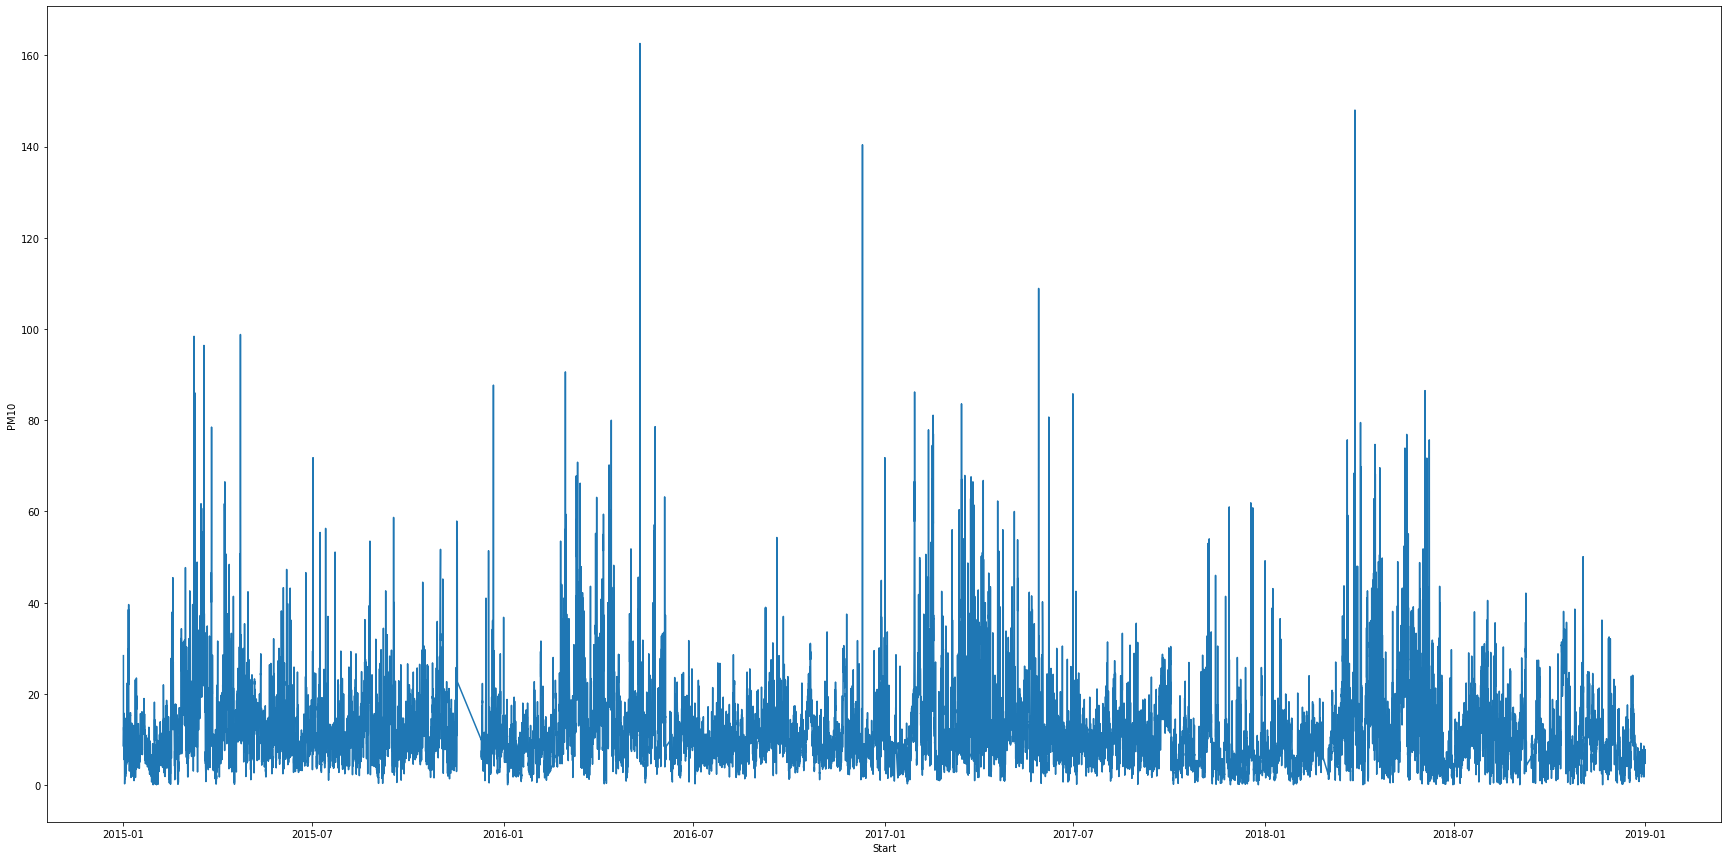

In [77]:
train.loc[train['PM10'] <= 0, 'PM10']=np.nan
train=train.set_index('Start')
train = train.assign(PM10=train['PM10'].interpolate(method='time'))
train=train.reset_index()
fig , ax =  plt.subplots(figsize=(30,15))
sns.lineplot(data=train,x="Start",y="PM10",ax=ax)

#### 2- Using Isolation Forest algorithm to find outliers


In [78]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(contamination=float(.001))
model.fit(train[['PM10']])
train['scores']=model.decision_function(train[['PM10']])
train['anomaly']=model.predict(train[['PM10']])
train.loc[train['anomaly'] == 1,'anomaly'] = 0
train.loc[train['anomaly'] == -1,'anomaly'] = 1
train['anomaly'].value_counts()

0    35031
1       33
Name: anomaly, dtype: int64

#### Viewing the outliers 

In [79]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.graph_objs as go
def plot_anomaly(df,metric_name):
    df.timestamp = pd.to_datetime(df['Start'].astype(str), format="%Y-%m-%d %H:%M:%S")
    dates = df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["PM10"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "rgb(228, 222, 249)", 1: "red"}
#Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2],
    # columnorder=[0, 1, 2,],
    header=dict(height=20,
                values=[['<b>Date</b>'], ['<b>Actual Values </b>'],
                        ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be')),
    cells=dict(values=[df.round(3)[k].tolist() for k in ['Start', 'PM10']],
               line=dict(color='#506784'),
               align=['center'] * 5,
               font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
               # format = [None] + [",.4f"] + [',.4f'],
               # suffix=[None] * 4,
               suffix=[None] + [''] + [''] + ['%'] + [''],
               height=27,
               fill=dict(color=[df['anomaly'].map(color_map)],#map based on anomaly level from dictionary
               )
               ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                     x=dates,
                     y=df['PM10'],
                     xaxis='x1', yaxis='y1',
                     mode='lines',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()
plot_anomaly(train,'anomalies')

ModuleNotFoundError: No module named 'chart_studio'

#### 3- Removing outliers and interpolating again

In [ ]:
train.loc[train['anomaly'] == 1 , 'PM10' ]= np.nan
train=train.set_index('Start')
train = train.assign(PM10=train['PM10'].interpolate(method='time'))
train=train.reset_index()
fig , ax =  plt.subplots(figsize=(30,15))
sns.lineplot(data=train,x="Start",y="PM10",ax=ax)

# 2) Building the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers